# Random split

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
from matplotlib import colormaps
import numpy as np

from utils import *
from calibrators import *

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from collections import Counter

## Functions

In [3]:
def create_split(calib_data, min_count=3, test_size=0.3):
    stratify_labels = [
        f"{cd.target_point[0]}_{cd.target_point[1]}" for cd in calib_data
    ]

    # Check distribution of stratification labels to ensure there's enough data for each category
    label_distribution = Counter(stratify_labels)

    # It's important that no label has too few samples to be split correctly
    # Adjust `min_count` based on your data size and the results of the distribution printout
    valid_indices = [
        i
        for i, label in enumerate(stratify_labels)
        if label_distribution[label] >= min_count
    ]

    # Filter data and labels to include only those that have enough samples
    filtered_data = [calib_data[i] for i in valid_indices]
    filtered_labels = [stratify_labels[i] for i in valid_indices]

    # Split data using train_test_split from scikit-learn, stratifying by the filtered labels
    return train_test_split(
        filtered_data, test_size=test_size, stratify=filtered_labels
    )

In [4]:
 def get_features(
    data: CalibrationData,
    with_face_transfrom=False,
    with_right_eye_transfrom=False,
    with_roll_pitch_yaw=False,
    with_look_at_point=False,
) -> list:
    default_list = list(data.gaze_point)

    if with_face_transfrom:
        default_list.extend(data.face_transform.flatten())
    if with_right_eye_transfrom:
        default_list.extend(data.right_eye_transform.flatten())
    if with_roll_pitch_yaw:
        default_list.extend(data.euler_angles)
    if with_look_at_point:
        default_list.extend(data.look_at_point)

    return default_list

In [5]:
def train_and_evaluate(
    train_data: [CalibrationData],
    test_data: [CalibrationData],
    extract_features: callable,
):
    lrc = LinearRegressionCalibrator(train_data, extract_features)
    return lrc, lrc.evaluate(test_data)

In [6]:
def extract_features_from_row(
    row,
    with_face_transfrom=False,
    with_right_eye_transfrom=False,
    with_roll_pitch_yaw=False,
    with_look_at_point=False,
):
    default = list((row["gazePointX"], row["gazePointY"]))

    if with_face_transfrom:
        default.extend(extract_face_transform(row).flatten())
    if with_right_eye_transfrom:
        default.extend(extract_face_transform(row, type="rightEyeTransform").flatten())
    if with_roll_pitch_yaw:
        default.extend(extract_euler_angles_from_matrix(extract_face_transform(row)))
    if with_look_at_point:
        default.extend(list(row[["lookAtPointX", "lookAtPointY", "lookAtPointZ"]]))

    return default

In [7]:
def calibrate_df(
    model: LinearRegressionCalibrator,
    df: pd.DataFrame,
    extract_features_from_row: callable,
):
    new_columns = df.apply(
        lambda row: model.calibrate(extract_features_from_row(row)),
        axis=1,
        result_type="expand",
    )

    # Assign new column names to the resulting DataFrame
    new_columns.columns = ["calibratedPointX", "calibratedPointY"]

    return pd.concat([df, new_columns], axis=1)

## Setup

In [8]:
df = load_df("data")
print("Dataframe size:", df.shape)
display(df.head())

Dataframe size: (900, 63)


,username,deviceName,position,distance,timestamp,targetPointX,targetPointY,gazePointX,gazePointY,faceTransform_0_x,...,leftEyeTransform_3_x,leftEyeTransform_3_y,leftEyeTransform_3_z,leftEyeTransform_3_w,lookAtPointX,lookAtPointY,lookAtPointZ,roll,pitch,yaw
0,victor,iPad Mini 6th,Middle,Regular,1.715694e+09,0.0,0.0,229.150642,146.014301,0.999920,...,0.031501,0.030555,0.025464,1.0,-0.107358,-0.088746,0.935463,1.349115,-0.681568,0.239772
1,victor,iPad Mini 6th,Middle,Regular,1.715694e+09,0.0,0.0,230.180792,145.479826,0.999916,...,0.031501,0.030555,0.025464,1.0,-0.107400,-0.088713,0.935594,1.330942,-0.702563,0.239077
2,victor,iPad Mini 6th,Middle,Regular,1.715694e+09,0.0,0.0,231.020193,146.354776,0.999914,...,0.031501,0.030555,0.025464,1.0,-0.107197,-0.088691,0.935635,1.337107,-0.709690,0.248199
3,victor,iPad Mini 6th,Middle,Regular,1.715694e+09,0.0,0.0,231.099802,146.935916,0.999912,...,0.031501,0.030555,0.025464,1.0,-0.107069,-0.088685,0.935711,1.337563,-0.713248,0.263629
4,victor,iPad Mini 6th,Middle,Regular,1.715694e+09,0.0,0.0,230.052845,149.130141,0.999914,...,0.031501,0.030555,0.025464,1.0,-0.107005,-0.088807,0.935693,1.375624,-0.703335,0.269881


In [9]:
calib_data = import_from_dataframe(df)
print(calib_data[0])
print("Calibration data size:", len(calib_data))

CalibrationData(username='victor', device_name='iPad Mini 6th', position=<HeadPosition.MIDDLE: 'Middle'>, distance=<PositionToScreen.REGULAR: 'Regular'>, timestamp=1715694046.711232, target_point=(0.0, 0.0), gaze_point=(229.15064203222903, 146.01430109941114), face_transform=array([[ 0.9999205 , -0.0044637 , -0.01179334,  0.        ],
       [ 0.0041845 ,  0.99971294, -0.02359388,  0.        ],
       [ 0.01189532,  0.02354266,  0.99965197,  0.        ],
       [ 0.06862871, -0.00328225, -0.38051197,  1.        ]]), right_eye_transform=array([[ 0.99653846, -0.01076515,  0.08243386,  0.        ],
       [ 0.        ,  0.9915805 ,  0.12949182,  0.        ],
       [-0.08313381, -0.12904358,  0.9881481 ,  0.        ],
       [-0.03144449,  0.03050292,  0.0254751 ,  1.        ]]), left_eye_transform=array([[ 0.9885571 , -0.01938766,  0.14959574,  0.        ],
       [ 0.        ,  0.99170613,  0.12852542,  0.        ],
       [-0.15084684, -0.12705474,  0.9803582 ,  0.        ],
       [ 0

In [10]:
# show_subplots(df)

In [11]:
# extract the target points and their gaze points
target_points = np.array([cd.target_point for cd in calib_data])
gaze_points = np.array([cd.gaze_point for cd in calib_data])

mse = mean_squared_error(target_points, gaze_points)
evaluation_without_calib = {
    "MSE": mse,
    "RMSE": np.sqrt(mse),
    "R2": r2_score(target_points, gaze_points),
}
print(evaluation_without_calib)

{'MSE': 336955.4639141604, 'RMSE': 580.4786506962683, 'R2': -1.728317695233347}


Now we are going to create 10 different splits of train and test data.

In [12]:
nb_splits = 10
splits = [create_split(calib_data) for _ in range(nb_splits)]

In [13]:
just_point = [
    train_and_evaluate(train_data, test_data, lambda data: get_features(data))
    for train_data, test_data in splits
]

face_transform = [
    train_and_evaluate(
        train_data, test_data, lambda data: get_features(data, with_face_transfrom=True)
    )
    for train_data, test_data in splits
]

roll_pitch_yaw = [
    train_and_evaluate(
        train_data, test_data, lambda data: get_features(data, with_roll_pitch_yaw=True)
    )
    for train_data, test_data in splits
]

face_and_rpy = [
    train_and_evaluate(
        train_data,
        test_data,
        lambda data: get_features(
            data, with_face_transfrom=True, with_roll_pitch_yaw=True
        ),
    )
    for train_data, test_data in splits
]

face_and_right_eye = [
    train_and_evaluate(
        train_data,
        test_data,
        lambda data: get_features(
            data, with_face_transfrom=True, with_right_eye_transfrom=True
        ),
    )
    for train_data, test_data in splits
]

face_rpy_and_right_eye = [
    train_and_evaluate(
        train_data,
        test_data,
        lambda data: get_features(
            data,
            with_face_transfrom=True,
            with_roll_pitch_yaw=True,
            with_right_eye_transfrom=True,
        ),
    )
    for train_data, test_data in splits
]

all_features = [
    train_and_evaluate(
        train_data,
        test_data,
        lambda data: get_features(
            data,
            with_face_transfrom=True,
            with_roll_pitch_yaw=True,
            with_right_eye_transfrom=True,
            with_look_at_point=True,
        ),
    )
    for train_data, test_data in splits
]

In [14]:
# create dictionary with all the results
results = {
    "just_point": just_point,
    "face_transform": face_transform,
    "roll_pitch_yaw": roll_pitch_yaw,
    "face_and_rpy": face_and_rpy,
    "face_and_right_eye": face_and_right_eye,
    "face_rpy_and_right_eye": face_rpy_and_right_eye,
    "all_features": all_features,
}

In [15]:
# for each result, compute median and std of the RMSE and R2
summary = {
    name: {
        "rmse": np.median([r[1]["RMSE"] for r in result]),
        "rmse_std": np.std([r[1]["RMSE"] for r in result]),
        "r2": np.median([r[1]["R2"] for r in result]),
        "r2_std": np.std([r[1]["R2"] for r in result]),
    }
    for name, result in results.items()
}

In [16]:
for name, s in summary.items():
    print(
        f"{name:25}: RMSE={s['rmse']:.2f}±{s['rmse_std']:.2f}, R2={s['r2']:.2f}±{s['r2_std']:.2f}"
    )

just_point               : RMSE=309.43±3.52, R2=0.30±0.01
face_transform           : RMSE=158.06±4.06, R2=0.84±0.01
roll_pitch_yaw           : RMSE=196.51±3.71, R2=0.71±0.01
face_and_rpy             : RMSE=154.89±4.53, R2=0.85±0.01
face_and_right_eye       : RMSE=122.41±3.79, R2=0.90±0.01
face_rpy_and_right_eye   : RMSE=111.63±2.97, R2=0.92±0.00
all_features             : RMSE=97.29±3.07, R2=0.93±0.00


In [17]:
names = list(summary.keys())


def create_plot(metric, values, stds):
    # Creating the bar plot with error bars
    plt.figure(figsize=(15, 10))
    plt.bar(names, values, yerr=stds, capsize=5, color="blue", alpha=0.7)
    plt.xlabel("Model Name")
    plt.ylabel(metric)
    plt.title(f"{metric} with Standard Deviation for Each Model")
    plt.show()

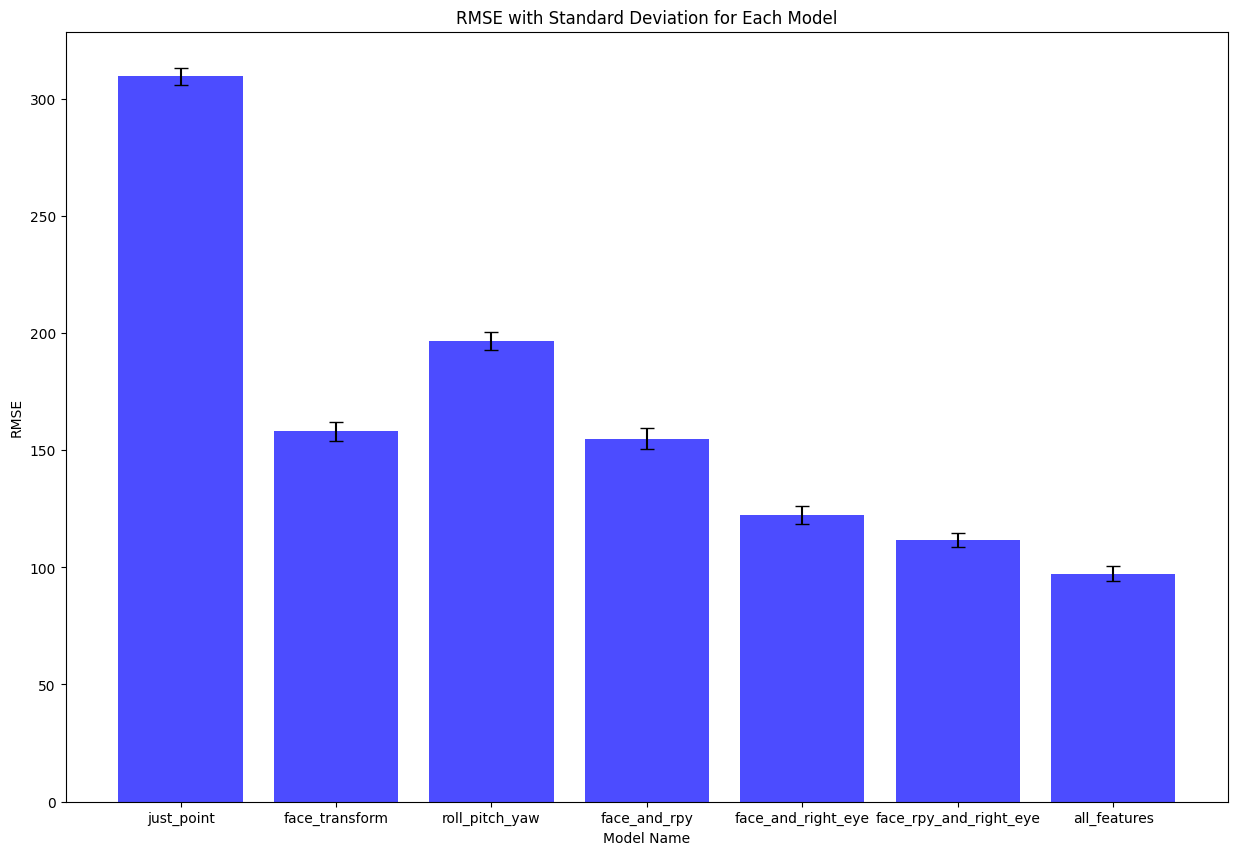

In [18]:
rmse_values = [s["rmse"] for s in summary.values()]
rmse_stds = [s["rmse_std"] for s in summary.values()]

create_plot("RMSE", rmse_values, rmse_stds)

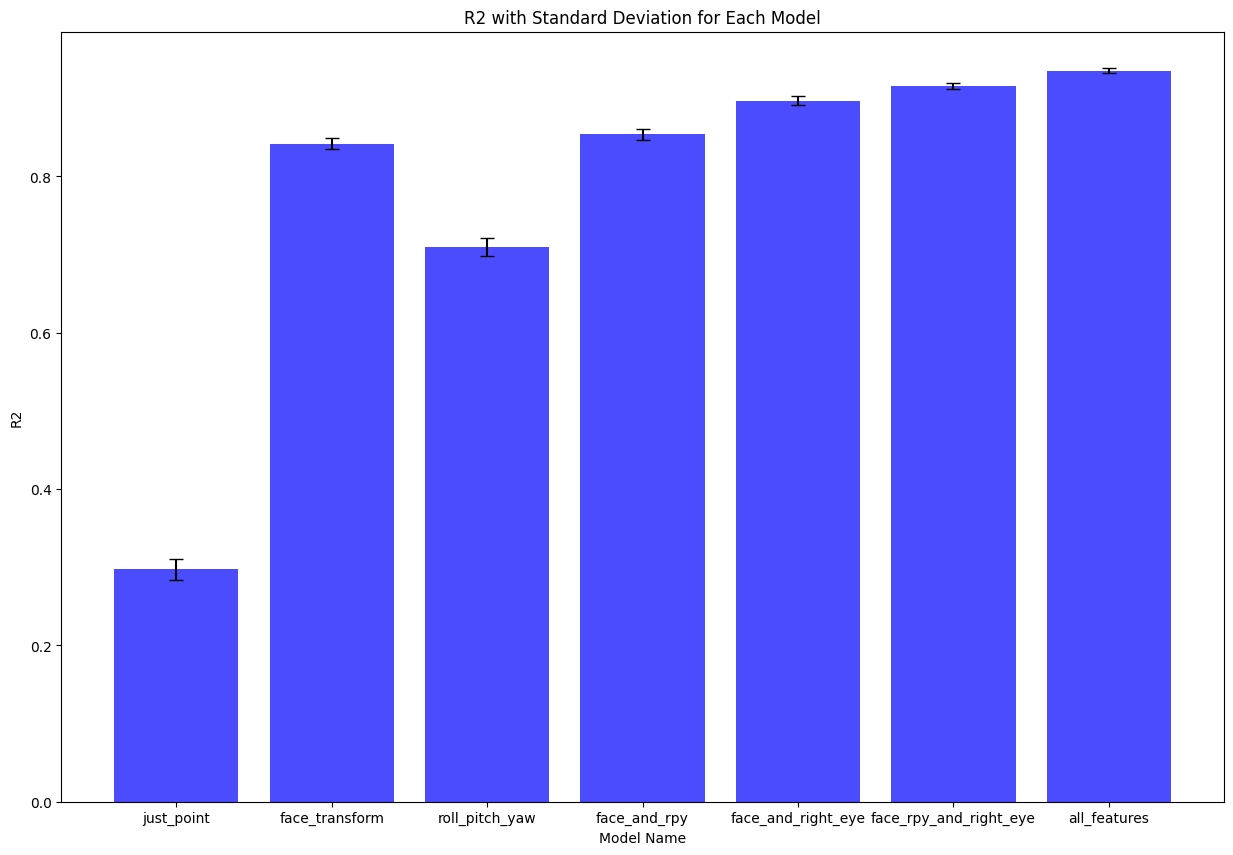

In [19]:
r2_values = [s["r2"] for s in summary.values()]
r2_stds = [s["r2_std"] for s in summary.values()]

create_plot("R2", r2_values, r2_stds)

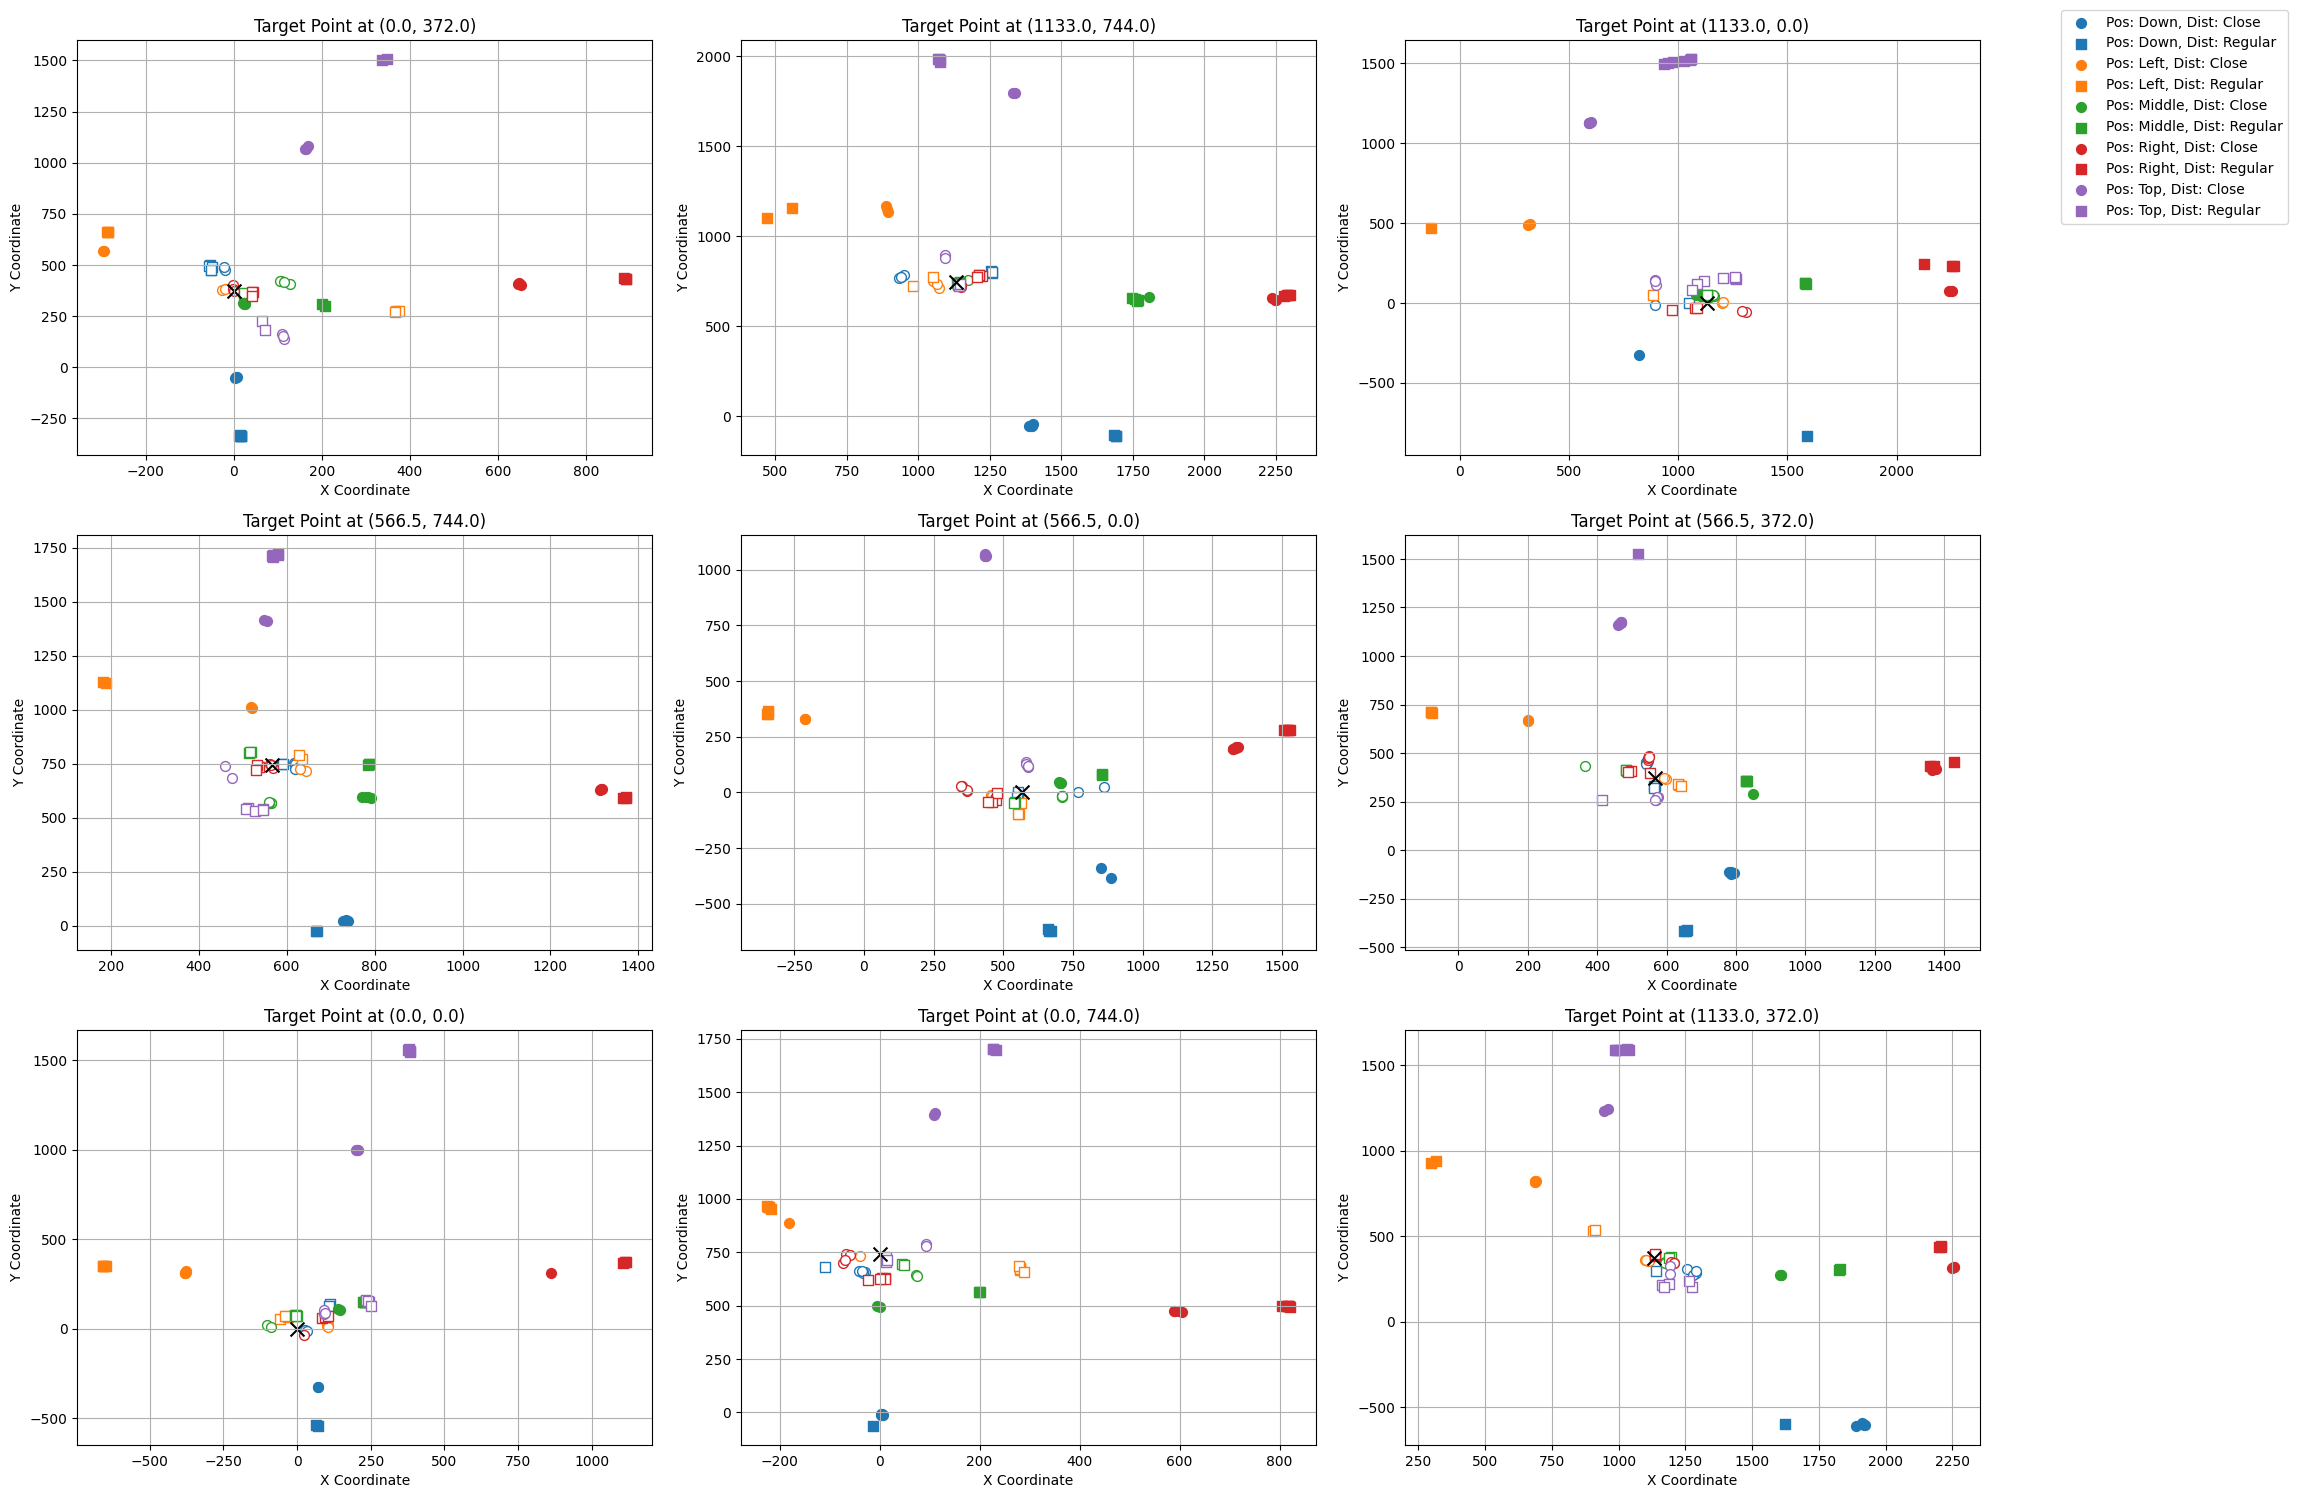

In [20]:
lrc, _ = all_features[0]
_, test_data = splits[0]
test_df = calib_data_to_dataframe(test_data)

calibrated_df = calibrate_df(
    lrc,
    test_df,
    lambda row: extract_features_from_row(
        row,
        with_face_transfrom=True,
        with_roll_pitch_yaw=True,
        with_right_eye_transfrom=True,
        with_look_at_point=True,
    ),
)

show_subplots(calibrated_df, with_calib=True)